# 1. Instalación de librerías

In [1]:
!pip install opencv-python numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\juanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# 2. Crear carpeta de salida

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
output_dir = 'Resultados'
os.makedirs(output_dir, exist_ok=True)
print(f"Guardar imágenes en: {os.path.abspath(output_dir)}")

Guardar imágenes en: d:\Computacion-Visual\2025-04-21_taller_segmentacion_formas\Python\Resultados


# 3. Función para mostrar imágenes con Matplotlib o OpenCV en escala de grises o color

In [4]:
def show_image(img, title="Imagen", cmap=None, filename=None):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.axis('off')
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    if filename:
        path = os.path.join(output_dir, filename)
        if cmap:
            plt.imsave(path, img, cmap=cmap)
        else:
            # BGR a RGB para guardar correctamente
            cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        print(f"Guardado: {path}")

# 4. Capturar un único frame de la webcam y procesarlo

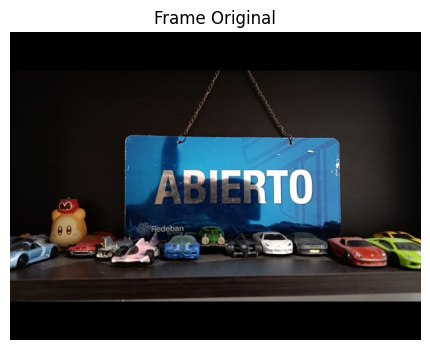

Guardado: Resultados\frame_original.png


In [5]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("No se pudo abrir la webcam")
ret, frame = cap.read()
cap.release()
if not ret:
    raise IOError("Error al capturar frame")
# Mostrar y guardar frame original
show_image(frame, title="Frame Original", filename='frame_original.png')


# 5. Preprocesamiento: Escala de grises y umbral fijo

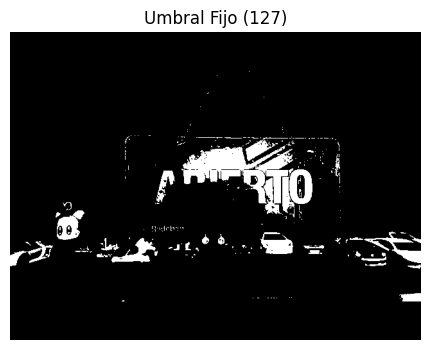

Guardado: Resultados\thresh_fixed.png


In [6]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, thresh_fixed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# Mostrar y guardar umbral fijo
show_image(thresh_fixed, title="Umbral Fijo (127)", cmap='gray', filename='thresh_fixed.png')


# 6. Detección de contornos

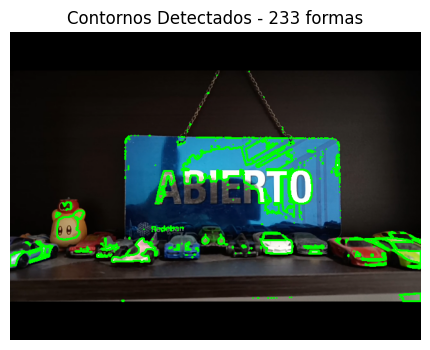

Guardado: Resultados\contours.png


In [7]:
detect_contours = lambda img: cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = detect_contours(thresh_fixed)

# Dibujar y guardar contornos
draw = frame.copy()
cv2.drawContours(draw, contours, -1, (0,255,0), 2)
show_image(draw, title=f"Contornos Detectados - {len(contours)} formas", filename='contours.png')

# 7. Cálculo de centro de masa y bounding boxes

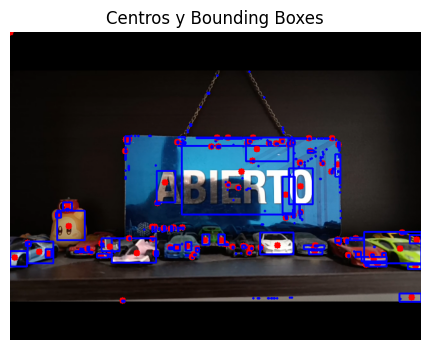

Guardado: Resultados\metrics.png


In [8]:
centers, bboxes, areas, perimeters = [], [], [], []
for cnt in contours:
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00']) if M['m00'] else 0
    cy = int(M['m01']/M['m00']) if M['m00'] else 0
    centers.append((cx, cy))
    bboxes.append(cv2.boundingRect(cnt))
    areas.append(cv2.contourArea(cnt))
    perimeters.append(cv2.arcLength(cnt, True))

# Dibujar métricas y guardar imagen
draw_metrics = frame.copy()
for (cx, cy), (x, y, w, h) in zip(centers, bboxes):
    cv2.circle(draw_metrics, (cx, cy), 5, (0, 0, 255), -1)
    cv2.rectangle(draw_metrics, (x, y), (x+w, y+h), (255, 0, 0), 2)
show_image(draw_metrics, title="Centros y Bounding Boxes", filename='metrics.png')

# 8. Métricas básicas

In [9]:
total = len(contours)
area_mean = np.mean(areas) if areas else 0
perimeter_mean = np.mean(perimeters) if perimeters else 0

print(f"Número de formas detectadas: {total}")
print(f"Área promedio: {area_mean:.2f} píxeles cuadrados")
print(f"Perímetro promedio: {perimeter_mean:.2f} píxeles")

Número de formas detectadas: 233
Área promedio: 71.73 píxeles cuadrados
Perímetro promedio: 23.85 píxeles


# 9. Bucle de procesamiento en tiempo real con guardado

In [11]:
print("Presiona 's' para guardar frame, 'q' para salir")
cap = cv2.VideoCapture(0)
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours = detect_contours(thresh)
    vis = frame.copy()

    areas_rt = []
    perims_rt = []
    for cnt in contours:
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00']) if M['m00'] else 0
        cy = int(M['m01']/M['m00']) if M['m00'] else 0
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        perim = cv2.arcLength(cnt, True)
        areas_rt.append(area)
        perims_rt.append(perim)
        cv2.drawContours(vis, [cnt], -1, (0,255,0), 1)
        cv2.circle(vis, (cx, cy), 3, (0,0,255), -1)
        cv2.rectangle(vis, (x, y), (x+w, y+h), (255,0,0), 1)

    # Calcular métricas en tiempo real
    count_rt = len(contours)
    area_mean_rt = np.mean(areas_rt) if areas_rt else 0
    perim_mean_rt = np.mean(perims_rt) if perims_rt else 0

    # Mostrar métricas sobre el frame
    info = [
        f"Count: {count_rt}",
        f"Mean Area: {area_mean_rt:.1f}",
        f"Mean Perim: {perim_mean_rt:.1f}"
    ]
    y0 = 20
    for i, text in enumerate(info):
        cv2.putText(vis, text, (10, y0 + i*20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    cv2.imshow('Visión en Vivo', vis)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):
        fname = f'frame_{count:03d}.png'
        cv2.imwrite(os.path.join(output_dir, fname), vis)
        print(f"Guardado: {os.path.join(output_dir, fname)}")
        count += 1
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



Presiona 's' para guardar frame, 'q' para salir
